#CLASIFICADOR DE IMAGENES PARA DETECTE LA NEUMONÍA


#####Con este modelo se pretende crear un clasificador de imágenes que sea capaz de detectar la neumonía. Para ello, se hará uso de la librería Fast.ai. 
#####Se ha utilizado el modelo ResNet 50 para crear este modelo. 
#####Se recomienda entrenarlo en Colab.

##### Dataset recuperado en: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/code 

##Conectar con google drive

In [4]:
import sys
def in_colab():
    "Check if the code is running in Google Colaboratory"
    return 'google.colab' in sys.modules

In [5]:
if in_colab():
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##Instalación de dependencias

In [7]:
if in_colab():
  !pip3 install --upgrade fastai > /dev/null

In [8]:
import fastai
import torch
f"fastai: {fastai.__version__}, pytorch: {torch.__version__}"

'fastai: 2.3.1, pytorch: 1.8.1+cu101'

#IMPORTACIONES

In [9]:
from fastai.vision.all import *
from pathlib import Path
from fastai.vision.widgets import *
from tqdm.auto import tqdm
import shutil

###GPU setup

La siguiente celda nos ayudará a asegurarnos que la GPU este disponible

In [10]:
assert torch.cuda.is_available(), "CUDA no es accesible!!!"

#OPTIONS

Asegura que tienes guardada la carpeta tfg en el drive. Formato: drive / tfg / archive.zip

In [11]:
archive = Path('/content/drive/MyDrive/tfg/archive.zip')

In [12]:
assert archive.exists(), "No tienes guardado el archivo.zip donde se ha especificado"

Con tal de ahorrar espacio y que el programa funcione más rápido, se guardará la carpeta con el dataset comprimido en formato zip.

Cada vez que se ejecute el programa se descomprimirá el archivo y se guardará en la maquina local.

In [13]:
!unzip '/content/drive/MyDrive/tfg/archive.zip' > /dev/null

Estudio del dataset, observo que las imagenes estan clasificadas por carpetas de test, train y val. Fast.ai ya hace la separación de train y val, por lo tanto, se reestructura el dataset según las especificaciones y se cambia el nombre de las imagenes.

In [14]:
IMAGE_PATH = Path('/content/Imagenes Pulmones')
IMAGE_PATH.mkdir(parents=True, exist_ok=True)
IMAGES_FOR_MODEL = IMAGE_PATH / 'Imagenes modelo' #poner IMAGES en ve de IMAGE

In [16]:
IM_PATH_NORMAL = IMAGES_FOR_MODEL / 'NORMAL'
IM_PATH_NORMAL.mkdir(parents=True, exist_ok=True)
IM_PATH_NEUMONIA = IMAGES_FOR_MODEL / 'NEUMONIA'
IM_PATH_NEUMONIA.mkdir(parents=True, exist_ok=True)

La carpeta chest_test se utilizará para comprobar el modelo creado.

In [17]:
chest_test = Path('/content/chest_xray/test')
shutil.move(str(chest_test) , str(IMAGE_PATH))

'/content/Imagenes Pulmones/test'

In [18]:
im_normal_test = Path('/content/Imagenes Pulmones/test/NORMAL')
im_neumonia_test = Path('/content/Imagenes Pulmones/test/PNEUMONIA')

In [19]:
chest_val_normal = Path('/content/chest_xray/val/NORMAL')
chest_train_normal =  Path('/content/chest_xray/train/NORMAL')
chest_val_pneumonia = Path('/content/chest_xray/val/PNEUMONIA')
chest_train_pneumonia =  Path('/content/chest_xray/train/PNEUMONIA')

In [20]:
im_val_normal = get_image_files(chest_val_normal)
im_train_normal = get_image_files(chest_train_normal)
im_normal = im_val_normal + im_train_normal

In [21]:
im_val_pneumonia = get_image_files(chest_val_pneumonia)
im_train_pneumonia = get_image_files(chest_train_pneumonia)
im_pneumonia = im_val_pneumonia + im_train_pneumonia

In [22]:
for im in im_normal:
  shutil.move(str(im),str(IM_PATH_NORMAL))
for im in im_pneumonia:
  shutil.move(str(im),str(IM_PATH_NEUMONIA))

###Se crea la carpeta donde se exportara el modelo

In [25]:
modelo = Path('/content/drive/MyDrive/tfg/modelo')
modelo.mkdir(parents=True, exist_ok=True)

###Cantidad de imágenes de imágenes 

In [30]:
print(f"Fotos de pulmones sanos: {len(im_normal)}")
print(f"Fotos de pulmones con neumonia: {len(im_pneumonia)}")
print(f"Fotos de pulmones sanos en test: {len(get_image_files(im_normal_test))}")
print(f"Fotos de pulmones con neumonia en test: {len(get_image_files(im_neumonia_test))}")


Fotos de pulmones sanos: 1349
Fotos de pulmones con neumonia: 3883
Fotos de pulmones sanos en test: 234
Fotos de pulmones con neumonia en test: 390


###Cambiar el nombre de las imagenes:

In [26]:
l=get_image_files(IMAGE_PATH)

In [27]:
identificador = 0
for im in sorted(list(l)):
  nuevo_nombre = f"{im.parents[0]}/{str(identificador).zfill(5)}.jpg"
  identificador = identificador + 1
  os.rename(str(im), nuevo_nombre)

#MODEL OPTIONS

In [29]:
BS = 20
EPOCHS = 20
WD = 1e-1
ITEM_IMAGE_SIZE = 224 

#MODEL

Se empieza definiendo el modelo y las especificaciones que tendrá el dataset.

In [31]:
chest = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items= get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y= parent_label,
    item_tfms=Resize(ITEM_IMAGE_SIZE)
    )

In [32]:
dls = chest.dataloaders(IMAGES_FOR_MODEL, bs=BS, wd=WD)
#len(dls.dataset)

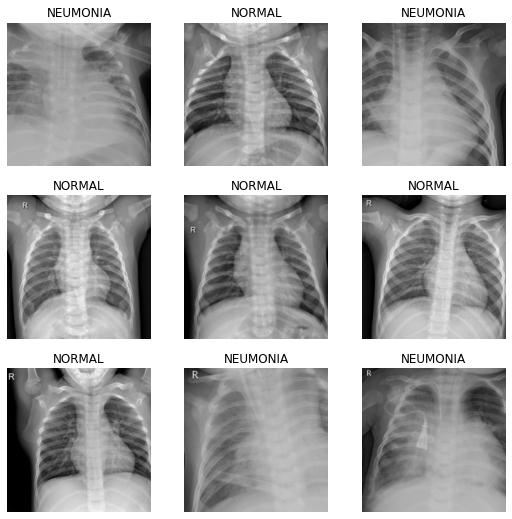

In [33]:
dls.show_batch()

##Se utiliza las redes neuronales convolucionales como extractoras de patrones.

In [34]:
learn = cnn_learner(dls, resnet50,
                    metrics=accuracy
                    )
                    #<- error_rate and accuracy are for single label classification problems
                    

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


##Fine-tuning

In [36]:
learn.fine_tune(EPOCHS)

epoch,train_loss,valid_loss,accuracy,time
0,0.360285,0.141391,0.953155,01:23


epoch,train_loss,valid_loss,accuracy,time
0,0.162415,0.088885,0.969407,01:25
1,0.097526,0.076271,0.976099,01:25
2,0.100405,0.061808,0.977055,01:26
3,0.086800,0.089192,0.965583,01:26
4,0.073530,0.028866,0.987572,01:25
5,0.066105,0.037398,0.988528,01:25
6,0.093714,0.037245,0.989484,01:25
7,0.057657,0.177817,0.959847,01:25
8,0.021068,0.074804,0.976099,01:25
9,0.082854,0.031182,0.988528,01:25


#INTERPRETACIÓN DE RESULTADOS

In [38]:
interp= ClassificationInterpretation.from_learner(learn)

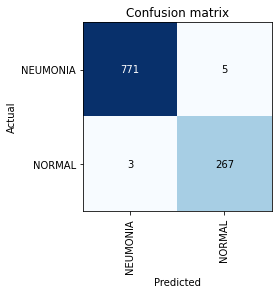

In [39]:
interp.plot_confusion_matrix()

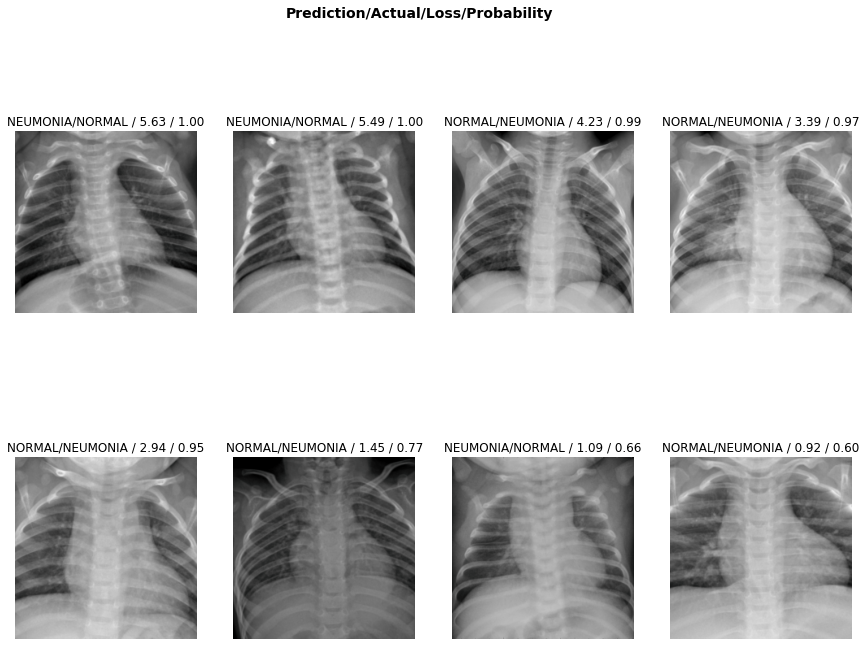

In [40]:
interp.plot_top_losses(8, figsize=(15,11))

# EXPORT

In [41]:
learn.export(modelo/'resnet50_modelo.pkl')